In [1]:
import pandas as pd
from sqlalchemy import create_engine, text


In [2]:
user = os.environ.get("DB_USER")
pw = os.environ.get("DB_PASSWORD")
db = os.environ.get("DB_USER")
host = os.environ.get("DB_HOST")
port = os.environ.get("DB_PORT")


uri = f"postgresql+psycopg2://{user}:{pw}@{host}:{port}/{db}"
engine = create_engine(uri)


In [3]:
query = text("SELECT * FROM records_5min_clean;")
conn = engine.connect()
df = pd.read_sql(query, conn)
conn.close()

In [4]:
df.columns

Index(['time', 'device_id', 'mass_concentration_pm1p0',
       'mass_concentration_pm2p5', 'mass_concentration_pm4p0',
       'mass_concentration_pm10p0', 'ambient_humidity', 'ambient_temperature',
       'voc_index', 'nox_index', 'hour', 'minute_of_hour', 'day_of_week',
       'day_name'],
      dtype='object')

In [5]:
cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0']
print(len(df))

for col in cols:
  df.loc[df[col] > 100, col] = 100


41128


In [6]:
df.loc[df['nox_index'] > 10, 'nox_index'] = 10

In [7]:
df.describe()

,device_id,mass_concentration_pm1p0,mass_concentration_pm2p5,mass_concentration_pm4p0,mass_concentration_pm10p0,ambient_humidity,ambient_temperature,voc_index,nox_index,hour,minute_of_hour,day_of_week
count,41128.000000,41128.000000,41128.000000,41128.000000,41128.000000,40675.000000,40675.000000,40675.000000,40675.000000,41128.000000,41128.000000,41128.000000
mean,34.703049,13.405850,14.642389,15.137848,15.380163,74.393799,10.384168,113.685910,1.436077,11.519986,27.478603,3.962848
std,3.032076,13.624296,14.108522,14.073537,14.068942,15.347719,3.582560,56.600634,0.968518,6.926753,17.251324,2.048630
min,31.000000,0.000000,0.000000,0.000000,0.000000,24.516667,1.390000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,32.000000,4.269167,5.322222,5.850000,6.066667,63.631667,8.103333,78.000000,1.000000,6.000000,10.000000,2.000000
50%,34.000000,8.200000,9.300000,10.022222,10.310000,75.370000,10.080000,100.666667,1.000000,11.000000,25.000000,4.000000
75%,37.000000,16.800000,17.824167,18.200000,18.550000,85.930000,12.376833,134.500000,2.000000,18.000000,40.000000,6.000000
max,40.000000,100.000000,100.000000,100.000000,100.000000,100.000000,36.225000,495.000000,10.000000,23.000000,55.000000,7.000000


Column transformer and the pipeline

In [8]:
from pickle import TRUE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import datetime as dt

#### Building a pipeline
class LSTMInputSequenceCreator(BaseEstimator, TransformerMixin):
    def __init__(self, sequence_length, location_col='pass_location_nickname', max_interval=dt.timedelta(minutes=30),stride=1):
        """
            Args:
                sequence_length (int): The length of every LSTM sequence
                max_interval (datetime.Timedelta): The maximum allowed difference between the delta between two consecutive timestamps and the mode delta to impute
                stride (int): The number of steps to move the sequence window by
        """
        self.sequence_length = sequence_length
        self.stride = stride
        self.interval_length = None
        self.allowed_interval_error = max_interval
        self.location_col = location_col
        self.columns = None

    def fit(self, X, y=None):
        self.columns = X.columns
        try:
            X = [x for x in self._split_dataframe_by_location(X)]
            print('N locations: ', len(X))
            self.set_interval_length(X)
        except KeyError:
            self.set_interval_length(X)
        return self

    def transform(self, X):
        print('Transforming')
        X = self.split_dataframe(X)
        print("Dataframe splitted")
        sequences = []
        targets = []

        processed = 0
        for i in range(len(X)):
            X[i] = self.interpolate_missing_timestamps(X[i])
            processed += len(X[i])
            if len(X[i]) < self.sequence_length:
                continue
            sequence, target = self._create_3d_array(X[i])
            sequences.append(sequence)
            targets.append(target)
            print(f'{processed} number of datapoints processed')
        sequences = np.concatenate(sequences)
        targets = np.concatenate(targets)
        return sequences, targets

    def type_check(self, dataframe):
        # Check if the index is a DateTimeIndex
        if isinstance(dataframe.index, pd.DatetimeIndex):
            # Check if all columns are int, float, or transformable to int or float
            if all(dataframe[col].dtype in [np.int64, np.float64] or pd.to_numeric(dataframe[col], errors='raise') for col in dataframe.columns):
                return dataframe.apply(pd.to_numeric, errors='raise')
            else:
                raise ValueError("The index is a DateTimeIndex, but some columns are not int, float, or transformable to int or float.")
        else:
            raise ValueError("The index is not a DateTimeIndex.")



    def interpolate_missing_timestamps(self, df):
        """
            Takes a list of dataframes and checks for missing timestamps
            If there are missing timestamps, the missing timestamps are imputed by linear interpolation
        """
        df = self.type_check(df)
        new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=self.interval_length)
        df_reindexed = df.reindex(df.index.union(new_index)).sort_index()

        new_df = df_reindexed.interpolate(method='time')
        new_df = new_df.reindex(new_index)

        return new_df

    def _create_3d_array(self, dataframe, drop_time=True):
        """
            Creates LSTM input sequences from a dataframe

            Args:
                dataframe (pd.DataFrame): The sequence dataframe
                drop_time (Boolean): Determines if the Day and Week columns should be dropped from the targets

            Returns:
                tuple(np.Array, np.Array): A tuple containing the sequences and the targets which are the consecutive values of the sequences
        """
        sequences = None
        targets = None

        # Convert dataframe to numpy array
        if isinstance(dataframe, pd.DataFrame):
            data = dataframe.values
            columns = dataframe.columns
            if drop_time:
              keep_columns = [i for i, col in enumerate(columns) if 'day' not in col and 'hour' not in col]
              # keep_columns = [i for i, col in enumerate(columns) if 'mass_concentration' in col]

        elif isinstance(dataframe, np.ndarray):
            data = dataframe
            if drop_time:
              raise ValueError('The time columns can only be dropped if the input data is a dataframe')

        else:
            raise ValueError("The dataframe must be a pandas dataframe or a numpy array")
        # Create sequences
        for i in range(0, len(data) - self.sequence_length, self.stride):
            sequence = data[i:i+self.sequence_length]
            n, f = sequence.shape
            sequence = sequence.reshape((1, n, f))
            target = data[i+self.sequence_length]

            if drop_time:
              target = target[keep_columns]

            out = len(target)
            target = target.reshape((1, out))
            if sequences is None:
                sequences = sequence
                targets = target
            else:
                sequences = np.concatenate([sequences, sequence])
                targets = np.concatenate([targets, target])

        # Convert sequences and targets to numpy arrays
        return sequences, targets

    def set_interval_length(self, data):
        """
            Sets the mode interval length of the dataframe

            Args:
                dataframe (pd.DataFrame): The sequence dataframe
                on_index (bool): If True, the interval length will be set based on the index of the dataframe which should be a timeseries
                timestamp_column (str): The name of the column to use as the timestamp (only applicable if 'on_index' is False)
        """
        if type(data) == list:
            for df in data:

                if type(df) != pd.DataFrame:
                    raise ValueError("All elements of the list must be pandas dataframes")
                if not isinstance(df.index, pd.DatetimeIndex):
                    raise ValueError("The index of the dataframes must be a datetime index")

            self.interval_length = pd.concat([df.index.round('5s').to_series().diff() for df in data]).mode().squeeze()




        elif type(data) == pd.DataFrame:
            if not isinstance(data.index, pd.DatetimeIndex):
                raise ValueError("The index of the dataframe must be a datetime index")
            self.interval_length = data.index.round('5s').to_series().diff().mode().squeeze()


    def _split_dataframe_by_location(self, df):
        """
            Splits a dataframe into sub-dataframes based on the location_nickname column
        """
        for name in df[self.location_col].unique():
            yield name, df[df[self.location_col] == name].drop(columns=self.location_col)


    def split_dataframe(self, dataframe):

        new_dataframes = []
        previous_timestamp = None
        current_group = []
        total = 0
        if self.location_col in dataframe.columns:

            for name, df in self._split_dataframe_by_location(dataframe):
                print(f'Total splitted: {total}')
                total += len(df)
                for timestamp in df.index:
                    if previous_timestamp is None:
                        current_group.append(timestamp)
                        previous_timestamp = timestamp

                    else:

                        timedelta = timestamp - previous_timestamp

                        if timedelta > self.allowed_interval_error:
                            new_dataframes.append(df.loc[current_group])
                            current_group = []
                            current_group.append(timestamp)
                            previous_timestamp = timestamp

                        else:
                            current_group.append(timestamp)
                            previous_timestamp = timestamp

                new_dataframes.append(df.loc[current_group])
                current_group = []
                previous_timestamp = None
        else:
            raise(ValueError(f"The dataframe must have a {self.location_col} column, the other option is not yet implemented"))
        return new_dataframes

In [9]:
rb_cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0', ]
mm_cols = ['voc_index', 'ambient_humidity','ambient_temperature', 'nox_index']
cat_cols = ['hour', 'day_of_week']

# col_trans = ColumnTransformer([('mm_scaler', MinMaxScaler(), rb_cols+mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
# col_trans = ColumnTransformer([('qt_scaler', QuantileTransformer(), rb_cols+mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
# col_trans = ColumnTransformer([('rb_scaler', RobustScaler(), rb_cols+mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
col_trans = ColumnTransformer([('qt_scaler', QuantileTransformer(), rb_cols), ('mm_scaler', MinMaxScaler(), mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
# col_trans = ColumnTransformer([('rb_scaler', RobustScaler(), rb_cols), ('rb_scaler_drop', RobustScaler(), mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
# col_trans = ColumnTransformer([('mm_scaler', RobustScaler(), rb_cols), ('mm_scaler_drop', RobustScaler(), mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
# col_trans = ColumnTransformer([('rb_scaler', RobustScaler(), rb_cols), ('mm_scaler', MinMaxScaler(), mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
col_trans.set_output(transform='pandas')

ColumnTransformer(transformers=[('qt_scaler', QuantileTransformer(),
                                 ['mass_concentration_pm1p0',
                                  'mass_concentration_pm2p5',
                                  'mass_concentration_pm4p0',
                                  'mass_concentration_pm10p0']),
                                ('mm_scaler', MinMaxScaler(),
                                 ['voc_index', 'ambient_humidity',
                                  'ambient_temperature', 'nox_index']),
                                ('time', OneHotEncoder(sparse_output=False),
                                 ['hour', 'day_of_week']),
                                ('pass', 'passthrough', ['device_id'])])

In [10]:
all_data = df.copy()

In [11]:
all_data.columns

Index(['time', 'device_id', 'mass_concentration_pm1p0',
       'mass_concentration_pm2p5', 'mass_concentration_pm4p0',
       'mass_concentration_pm10p0', 'ambient_humidity', 'ambient_temperature',
       'voc_index', 'nox_index', 'hour', 'minute_of_hour', 'day_of_week',
       'day_name'],
      dtype='object')

In [12]:
print(len(all_data))
col_trans.fit(all_data)

41128


ColumnTransformer(transformers=[('qt_scaler', QuantileTransformer(),
                                 ['mass_concentration_pm1p0',
                                  'mass_concentration_pm2p5',
                                  'mass_concentration_pm4p0',
                                  'mass_concentration_pm10p0']),
                                ('mm_scaler', MinMaxScaler(),
                                 ['voc_index', 'ambient_humidity',
                                  'ambient_temperature', 'nox_index']),
                                ('time', OneHotEncoder(sparse_output=False),
                                 ['hour', 'day_of_week']),
                                ('pass', 'passthrough', ['device_id'])])

In [13]:
all_data.index = pd.to_datetime(all_data['time'])
new_data = col_trans.transform(all_data)
new_data.isna().sum()

qt_scaler__mass_concentration_pm1p0       0
qt_scaler__mass_concentration_pm2p5       0
qt_scaler__mass_concentration_pm4p0       0
qt_scaler__mass_concentration_pm10p0      0
mm_scaler__voc_index                    453
mm_scaler__ambient_humidity             453
mm_scaler__ambient_temperature          453
mm_scaler__nox_index                    453
time__hour_0.0                            0
time__hour_1.0                            0
time__hour_2.0                            0
time__hour_3.0                            0
time__hour_4.0                            0
time__hour_5.0                            0
time__hour_6.0                            0
time__hour_7.0                            0
time__hour_8.0                            0
time__hour_9.0                            0
time__hour_10.0                           0
time__hour_11.0                           0
time__hour_12.0                           0
time__hour_13.0                           0
time__hour_14.0                 

In [14]:
new_data.dropna(inplace=True)

In [15]:
############## Test vs Train
train = []
test = []

for id, df_ in new_data.groupby('pass__device_id', as_index=False):
    split = int(len(df_) * 0.8)
    train.append(df_.iloc[:split])
    test.append(df_.iloc[split:])

train_df = pd.concat(train)
test_df = pd.concat(test)



In [16]:
len(train_df)

32536

In [17]:
lstm_formatter = LSTMInputSequenceCreator(sequence_length=20, location_col='pass__device_id', max_interval=dt.timedelta(minutes=10) ,stride=1)
dataframes = lstm_formatter.split_dataframe(new_data)

Total splitted: 0
Total splitted: 7016
Total splitted: 12913
Total splitted: 18393
Total splitted: 23532
Total splitted: 25480
Total splitted: 27395
Total splitted: 30972
Total splitted: 33456
Total splitted: 37163


In [18]:
dataframes[0]

,qt_scaler__mass_concentration_pm1p0,qt_scaler__mass_concentration_pm2p5,qt_scaler__mass_concentration_pm4p0,qt_scaler__mass_concentration_pm10p0,mm_scaler__voc_index,mm_scaler__ambient_humidity,mm_scaler__ambient_temperature,mm_scaler__nox_index,time__hour_0.0,time__hour_1.0,...,time__hour_21.0,time__hour_22.0,time__hour_23.0,time__day_of_week_1.0,time__day_of_week_2.0,time__day_of_week_3.0,time__day_of_week_4.0,time__day_of_week_5.0,time__day_of_week_6.0,time__day_of_week_7.0
time,,,,,,,,,,,,,,,,,,,,,
2024-03-02 10:25:00,0.013514,0.018018,0.025742,0.029259,0.000000,0.142725,0.546290,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:30:00,0.013514,0.018018,0.025742,0.029259,0.000000,0.142725,0.546290,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:35:00,0.008008,0.027027,0.049049,0.062563,0.000000,0.142725,0.546290,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:40:00,0.017017,0.021772,0.029667,0.033200,0.131511,0.239435,0.458610,0.066667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:45:00,0.045045,0.031118,0.032032,0.034034,0.199393,0.278847,0.437347,0.100000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 00:00:00,0.566900,0.555756,0.513407,0.502804,0.148223,0.515419,0.269493,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-05 00:05:00,0.587588,0.580303,0.543766,0.532866,0.145749,0.517009,0.268855,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-05 00:10:00,0.559059,0.549049,0.507508,0.495996,0.143725,0.518702,0.269269,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def create_3d(dataframes):
  sequences = []
  targets = []
  processed = 0

  for i in range(len(dataframes)):

      sequence, target = lstm_formatter._create_3d_array(dataframes[i])
      if sequence is None:
          continue
      sequences.append(sequence)
      targets.append(target)
      processed += len(sequence)
      print(f'Processed {processed} data points')

  sequences = np.concatenate(sequences)
  targets = np.concatenate(targets)
  return sequences, targets

In [20]:
X_all, y_all = create_3d(dataframes)

Processed 724 data points
Processed 5545 data points
Processed 6942 data points
Processed 7376 data points
Processed 8016 data points
Processed 11368 data points
Processed 12699 data points
Processed 18159 data points
Processed 18183 data points
Processed 21804 data points
Processed 23140 data points
Processed 23165 data points
Processed 23170 data points
Processed 23177 data points
Processed 23183 data points
Processed 23213 data points
Processed 23222 data points
Processed 23257 data points
Processed 23307 data points
Processed 23313 data points
Processed 23947 data points
Processed 24567 data points
Processed 24780 data points
Processed 24793 data points
Processed 24830 data points
Processed 24839 data points
Processed 24941 data points
Processed 24943 data points
Processed 25058 data points
Processed 25114 data points
Processed 25123 data points
Processed 25343 data points
Processed 26133 data points
Processed 29209 data points
Processed 29219 data points
Processed 29281 data point

In [21]:
with open('5min/20_10/X_train_qt.npy', 'wb') as f:
    np.save(f, X_all)
with open('5min/20_10/y_train_qt.npy', 'wb') as f:
    np.save(f, y_all)

In [22]:
# X_train = np.load('5min/20_10/X_train_qt.npy')
# y_train = np.load('5min/20_10/y_train_qt.npy')

In [23]:
columns = new_data.columns.tolist()
columns.remove('pass__device_id')
print(columns)

['qt_scaler__mass_concentration_pm1p0', 'qt_scaler__mass_concentration_pm2p5', 'qt_scaler__mass_concentration_pm4p0', 'qt_scaler__mass_concentration_pm10p0', 'mm_scaler__voc_index', 'mm_scaler__ambient_humidity', 'mm_scaler__ambient_temperature', 'mm_scaler__nox_index', 'time__hour_0.0', 'time__hour_1.0', 'time__hour_2.0', 'time__hour_3.0', 'time__hour_4.0', 'time__hour_5.0', 'time__hour_6.0', 'time__hour_7.0', 'time__hour_8.0', 'time__hour_9.0', 'time__hour_10.0', 'time__hour_11.0', 'time__hour_12.0', 'time__hour_13.0', 'time__hour_14.0', 'time__hour_15.0', 'time__hour_16.0', 'time__hour_17.0', 'time__hour_18.0', 'time__hour_19.0', 'time__hour_20.0', 'time__hour_21.0', 'time__hour_22.0', 'time__hour_23.0', 'time__day_of_week_1.0', 'time__day_of_week_2.0', 'time__day_of_week_3.0', 'time__day_of_week_4.0', 'time__day_of_week_5.0', 'time__day_of_week_6.0', 'time__day_of_week_7.0']


In [24]:
X_all[0][10]

array([0.02274682, 0.01078857, 0.01274656, 0.01241723, 0.19095816,
       0.31989402, 0.35698451, 0.1       , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        ])

In [25]:
y_all[0].shape

(8,)

(array([251., 125.,  85.,  54.,  45.,  48.,  42.,  51.,  34.,   9.]),
 array([8.42509176e-04, 1.00758258e-01, 2.00674007e-01, 3.00589756e-01,
        4.00505506e-01, 5.00421255e-01, 6.00337004e-01, 7.00252753e-01,
        8.00168502e-01, 9.00084251e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

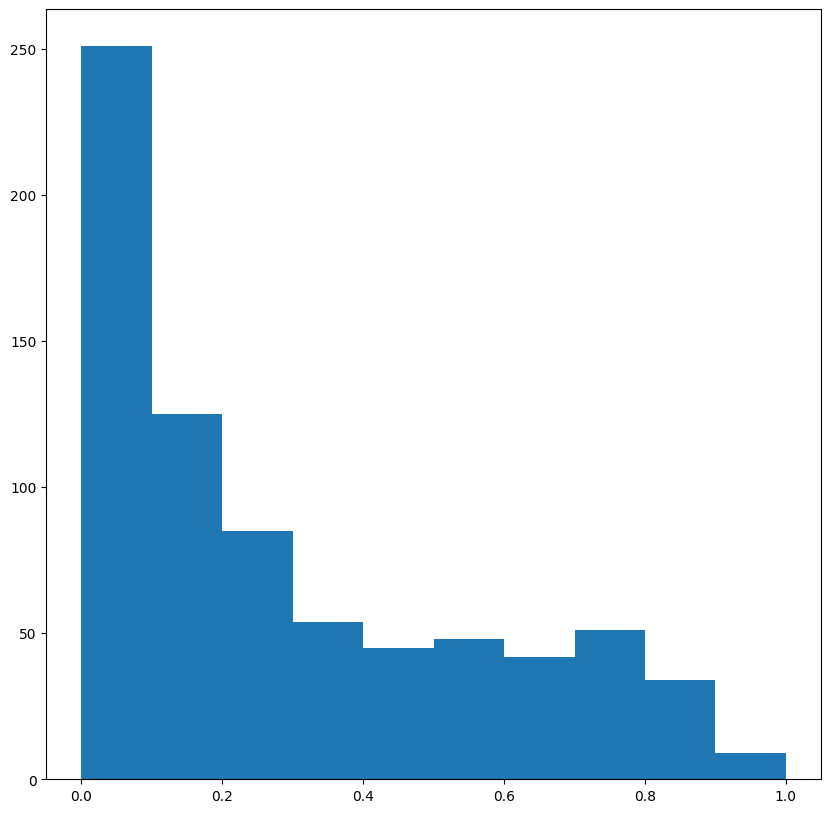

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# plt.hist(dataframes[0]['mm_scaler__mass_concentration_pm1p0'])
# plt.hist(dataframes[0]['rb_scaler__mass_concentration_pm10p0'])
plt.hist(dataframes[0]['qt_scaler__mass_concentration_pm10p0'])

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



# Define the input shape
input_shape = X_all[0].shape
output_shape = y_all.shape[1]
print('Input shape:', input_shape)

# Define the LSTM-based neural network
inputs = Input(shape=input_shape)
lstm_layer = LSTM(256)(inputs)
dense = Dense(128, activation='relu')(lstm_layer)
dense = Dense(64, activation='relu')(dense)
output = Dense(output_shape, 'linear')(dense)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mae'])

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

# Callbacks
early_stopping=EarlyStopping(patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)


history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

Input shape: (20, 39)
Epoch 1/100
219/219 [==============================] - 5s 8ms/step - loss: 0.0639 - mae: 0.1694 - val_loss: 0.0129 - val_mae: 0.0881 - lr: 5.0000e-05
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0098 - mae: 0.0686 - val_loss: 0.0087 - val_mae: 0.0682 - lr: 5.0000e-05
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0076 - mae: 0.0576 - val_loss: 0.0074 - val_mae: 0.0610 - lr: 5.0000e-05
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0067 - mae: 0.0523 - val_loss: 0.0068 - val_mae: 0.0574 - lr: 5.0000e-05
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0062 - mae: 0.0489 - val_loss: 0.0063 - val_mae: 0.0543 - lr: 5.0000e-05
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0058 - mae: 0.0462 - val_loss: 0.0061 - val_mae: 0.0526 - lr: 5.0000e-05
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0

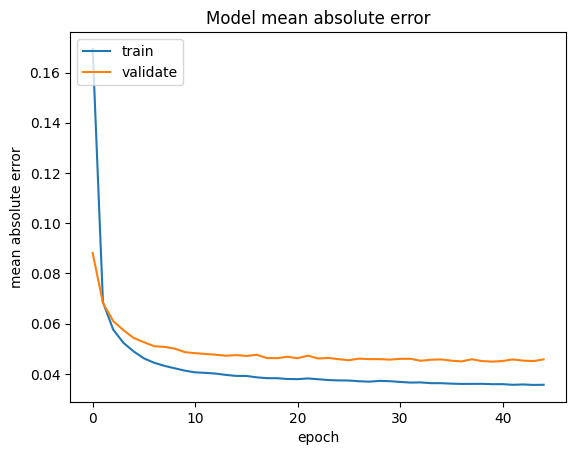

In [40]:
# summarize history of absolute error
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

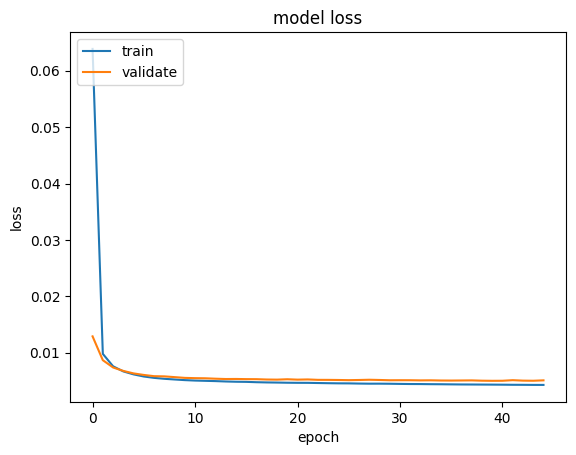

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [30]:
y_pred = model.predict(X_test)
y_pred.shape

244/244 [==============================] - 1s 3ms/step


(7783, 8)

In [31]:
def inverse_scale(col_trans, data):
  data=data.copy()
  for transformer in col_trans.transformers_:
    if transformer[0] == 'rb_scaler':
      columns_rb = col_trans.output_indices_['rb_scaler']
      data[:, columns_rb] = transformer[1].inverse_transform(data[:, columns_rb])

    elif transformer[0] == 'mm_scaler':
        columns_mm = col_trans.output_indices_['mm_scaler']
        data[:, columns_mm] = transformer[1].inverse_transform(data[:, columns_mm])

    elif transformer[0] == 'qt_scaler':
        columns = col_trans.output_indices_['qt_scaler']
        data[:, columns] = transformer[1].inverse_transform(data[:, columns])

    elif transformer[0] == 'time':
        pass
  return data

i_scaled = inverse_scale(col_trans, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [32]:
print(i_scaled[:10])

[[ 14.457574    16.249966    16.058212    15.52568    100.08977
  100.282906     8.813182     1.7078595 ]
 [  8.215238     8.642453     8.950291     8.8         47.75905
   84.174       12.882218     2.894974  ]
 [ 13.414101    14.540324    14.078204    14.103587   128.37793
   63.664932    14.399463     0.9587573 ]
 [  8.597056     8.913413     9.302604     8.93943     86.30782
   74.165825    12.995658     1.7640088 ]
 [  3.75         6.552568     8.75         9.810975   107.095245
   86.19945      6.5142913    1.2672461 ]
 [ 11.857847    12.323437    12.5589485   12.388949   181.98561
   60.07269     17.312769     0.91798925]
 [  5.75        10.997956    14.271499    15.947816    54.409218
   83.68478     10.622139     1.11573   ]
 [ 12.807464    13.89099     13.961791    13.757063   211.36375
   91.831635    10.721003     0.9888563 ]
 [  5.81059      6.4496737    6.65135      6.5487204   88.60811
   58.638557     7.7802925    1.9344269 ]
 [  5.1          6.1          6.845736     6

In [33]:
y_is = inverse_scale(col_trans, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [34]:
x_last = [x[-1] for x in X_test]
x_last = np.array(x_last)
print(x_last.shape)

(7783, 39)


In [35]:
x_last = x_last[:, :8]

In [36]:
x_last = inverse_scale(col_trans, x_last)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [37]:
abs_errors = abs(i_scaled - y_is)
abs_errors_base = abs(x_last - y_is)
for i in range(8):
  print('Prediction error: ', abs_errors[:, i].mean())
  print('Baseline error: ', abs_errors_base[:, i].mean(), '\n')

Prediction error:  2.6906716969735567
Baseline error:  1.995467255033216 

Prediction error:  3.110607351161557
Baseline error:  2.1930814793215223 

Prediction error:  3.2142617426917126
Baseline error:  2.349750957643961 

Prediction error:  2.8619999162531524
Baseline error:  2.436548709765496 

Prediction error:  19.680200123682575
Baseline error:  19.737364487245635 

Prediction error:  0.9740989109846311
Baseline error:  0.5404261473836026 

Prediction error:  0.32956230867915465
Baseline error:  0.11076225747808043 

Prediction error:  0.15862823348399005
Baseline error:  0.06532836880951362 

